<a href="https://colab.research.google.com/github/hf2000510/twitter-poll/blob/master/twitter_pol_prediction_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showcasing the full prediction workflow for the pretrained model

## imports and setup

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
!pip install mpld3
import mpld3
mpld3.enable_notebook()

import numpy as np
import pandas as pd
import pickle

%tensorflow_version 2.x
import tensorflow as tf
!pip install transformers
import transformers
from transformers import AutoTokenizer

import warnings
warnings.filterwarnings('ignore')

!pip install TwitterSearch
from TwitterSearch import *
from os import listdir
import importlib.util

import nltk
nltk.download('stopwords')
import re
import string

import typing
from typing import *

You need Twitter API access (follow [these docs](https://developer.twitter.com/en/docs/labs/filtered-stream/quick-start)). You can either store the credentials as below in a keyfile.py or just manually enter them below when needed (you then don't need to execute the next cell).

In [0]:
spec = importlib.util.spec_from_file_location("keyfile", "/content/drive/My Drive/twitter_pol/keyfile.py")  # twitter api access tokens are stored in the keyfile
keyfile = importlib.util.module_from_spec(spec)
spec.loader.exec_module(keyfile)

## Functions etc.

In [0]:
# functions to clean the tweets
def remove_URL(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

exclude = set(string.punctuation)
def remove_punct(text):
    text = ''.join(ch for ch in text if ch not in exclude)
    text = text.replace('\n', ' ').replace('\r', '')
    return text

## functions and tokenizer for the model

In [0]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    '''
    texts: list of strings, each string one text to be encoded (e.g. ["First tweet text", "Second tweet text", ...])
    tokenizer: a BERT tokenizer (e.g. AutoTokenizer.from_pretrained("bert-base-german-cased"))
    max_len: maximum length of each string (number of words!) in the texts list

    output: tuple of BERT encodings of the input texts: (word_ids, attention_masks, segment_ids)
    '''
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## functions to get tweets etc.

In [0]:
def tweets_from_usernames(usernames: List[str], party_id: int, num_parties=6) -> List[Any]:
    '''
    usernames: List of twitter handles; have to be from the same party
    party_id: int to assign the tweets to a class (e.g. 1 -> returns [[tweet, 1, 0, 0, 0, 0, 0], ...])
    num_parties: total number of parties

    returns list of lists, with each list of form [tweet, 0, 0, 1, 0, 0] with 1 at party_id (e.g. here = 3) and num_parties 0s and 1s
    '''
    ts = TwitterSearch(
        # ***************** YOUR CREDENTIALS HERE ***********************
        consumer_key = keyfile.consumer_key,
        consumer_secret = keyfile.consumer_secret,
        access_token = keyfile.access_token,
        access_token_secret = keyfile.access_token_secret
     )

    all_users_combined = []
    one_hot_enc_mask = [0] * num_parties
    one_hot_enc_mask[party_id - 1] = 1

    for username in usernames:
        try:
            tuo = TwitterUserOrder(username)
            tuo.set_include_rts(False)
            tuo.arguments.update({'tweet_mode':'extended'})  # change to Twitter API -> text truncated by default -> set to extended

            for index, tweet in enumerate(ts.search_tweets_iterable(tuo)):
                tweet_content = tweet['full_text']
                all_users_combined.append([tweet_content] + one_hot_enc_mask)
                if index == 99:  # 100 tweets per user
                    break

        except TwitterSearchException as e:
            print(e, username)

    return all_users_combined

In [0]:
# concat to 500 each
def concat_tweets(tweets_with_one_hot):
    '''
    tweets_with_one_hot: List of form [[tweet, 1, 0, 0], ...]

    returns list of tweets with each sublist having <= 500 tokens
    '''
    concatenated_tweets = []
    one_hot_enc_mask = tweets_with_one_hot[0][1:]
    curr = ""
    for tweet_with_one_hot in tweets_with_one_hot:
      tweet_content = tweet_with_one_hot[0]
      if len(curr) + len(tweet_content.split()) <= 500:
        curr += " " + tweet_content
      else:
        concatenated_tweets.append([curr] + one_hot_enc_mask)
        curr = tweet_content
    if curr:
      concatenated_tweets.append([curr] + one_hot_enc_mask)
    
    return concatenated_tweets

# getting model and predicting
The model is stored in [google drive](https://drive.google.com/open?id=1-1qIYDXzAMfUhH0Z57wBsaX_PGljNPbs) as my_model.h5py . Just download the whole thing (*the whole folder!*) and upload it to your google drive for use with colab.

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/twitter_pol/my_model.h5py', custom_objects=None, compile=True)

In [0]:
def username_to_prediction(username):
  '''
  username: valid twitter username as string (user must not be private)

  returns tuple (username, pred) where pred is 6-dimensional array of softmax output
  '''
  # get and concat (to <= 500 each) and concat up to 100 tweets of the given username
  list_of_tweets = [remove_URL(remove_html(remove_punct(tweet[0]))) for tweet in concat_tweets(tweets_from_usernames([username], party_id=1, num_parties=2))]
  # encode the user's tweets
  network_input = bert_encode(list_of_tweets, tokenizer, max_len=500)
  # get the network's predictions
  preds = model.predict(network_input, verbose=0)
  return username, np.mean(preds, axis=0)

def plot_prediction(username, user_prediction):
  fig, ax = plt.subplots()
  rects1 = ax.bar(np.arange(len(np.squeeze(user_prediction))),np.squeeze(user_prediction))
  ax.set_xticks(np.arange(len(np.squeeze(user_prediction))))
  ax.set_xticklabels(("linke", "green", "spd", "fdp", "cdu", "afd"))
  ax.set_ylabel('Confidence')
  ax.set_xlabel('Party')
  ax.yaxis.set_label_coords(-0.12,0.5)
  title = "username: " + username
  ax.set_title(title)
  plt.show()

def username_to_plot(username):
  plot_prediction(*username_to_prediction(username))  

# Examples

Official account of SPD in Hamburg

In [13]:
username_to_prediction("SPDhh")

('SPDhh', array([9.7734565e-03, 8.3710089e-02, 6.1425084e-01, 3.0992078e-02,
        2.6075315e-01, 5.2038697e-04], dtype=float32))

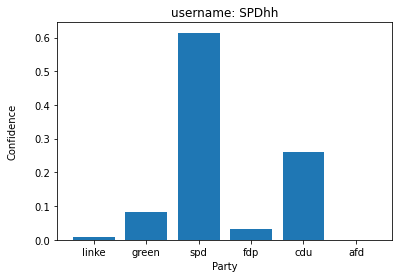

In [12]:
username_to_plot("SPDhh")

Official account of Green Party


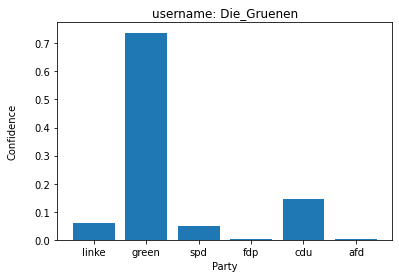

In [14]:
username_to_plot("Die_Gruenen")